In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 60

### Here lives some of the functions used in the rest of the notebook

In [2]:
def fix_time(time_start,x):
    if datetime.combine(date.min, x) >= datetime.combine(date.min, time_start):
        start = (datetime.combine(date.min, x) - datetime.combine(date.min, time_start)).total_seconds()
    else:
        #ex: this is the case when time_start is 59:00 min and x is 02:00 min, so we add an hour to find the duration
        start = (datetime.combine(date.min, x) + timedelta(hours=1) - datetime.combine(date.min, time_start)).total_seconds()
    return start

def get_duration(row):
    if pd.notnull(row['Timeshifted']): #check that not last action which will have no Timeshifted value
        if datetime.combine(date.min, row['Timeshifted']) >= datetime.combine(date.min, row['Time']):
            duration = (datetime.combine(date.min, row['Timeshifted']) - datetime.combine(date.min, row['Time'])).total_seconds()
        else:
            #ex: this is the case when time_start is 59:00 min and x is 02:00 min, so we add an hour to find the duration
            duration = (datetime.combine(date.min, row['Timeshifted']) + timedelta(hours=1) - datetime.combine(date.min, row['Time'])).total_seconds()
    else:
        duration = 10 #last action lasts zero seconds but we need to put a dummy variable here.
    return duration

def get_action_usage(df,column,action):
    '''for each action, we detect its use in a particular column
    and then extract a list of time coordinates for when
    they were used. These coordinates are in the format (start_time, duration)'''

    usage = zip(df[df[column].str.contains(action,na=False)]['Time_seconds'],df[df[column].str.contains(action,na=False)]['Duration'])
    return usage

# The data

In [3]:
df_all = pd.read_excel('all data v3.xlsx', 'iLab data.txt', index_col=None, na_values=['NA'])

### Preparing a test sample
Let's first use a particular session as a test case. We extract only the data relevant to that case

In [4]:
#Using the example used for sketch.
#(df_all.condition1 == 'Savanna') & (df_all.student1 == 'penguin') & (df_all.student2 == 'gorilla')]
df_test = df_all[df_all['Session Id'] == 'L-2567b17a:120eda25685:-8000']

Next we filter out all actions with "INCORRECT" outcomes

In [5]:
before = df_test.shape[0]
df_test = df_test[df_test['Outcome'] == 'CORRECT']
print "We are left with {0} rows out of {1}".format(df_test.shape[0],before)

We are left with 212 rows out of 285


### We need to extract the time stamp of each action and it's duration

Next we fix the time logs and convert them to seconds. We also recalculate the time between actions now that we have gotten rid of incorrect actions.

In [6]:
time_start = list(df_test['time first action'])[0]
df_test['Time_seconds'] = df_test[['Time']].applymap(lambda x: fix_time(time_start,x) )
df_test['Timeshifted'] = df_test[['Time']].shift(-1)
df_test['Duration'] = df_test[['Time','Timeshifted']].apply(get_duration, axis=1)

### A first plot

In [7]:
color = {"Now try working on this new example":"#252525",
         "intuition": "#bdbdbd",
         "submit": "#969696",
         "evaluation": "#737373",
         "checkIntuition": "#525252",
         'Median': "#33a02c",
         'Average': "#6a3d9a",
         'Sum': "#1f78b4",
         'all': "#ff7f00",
        }
column_to_use = {"Now try working on this new example":"Feedback Text",
                 "intuition": "Selection",
                 "submit": "Selection",
                 "evaluation": "Selection",
                 "checkIntuition": "Selection",
                 "Now try working on this new example":"Feedback Text",
                 'Median': 'Method_Recognized_1_Copied',
                 'Average': 'Method_Recognized_1_Copied',
                 'Sum': 'Method_Recognized_1_Copied',
                 'all': 'Method_Recognized_1_Copied',
                }
to_plot = ["intuition","submit","evaluation","checkIntuition",'Median','Average','Sum','all']

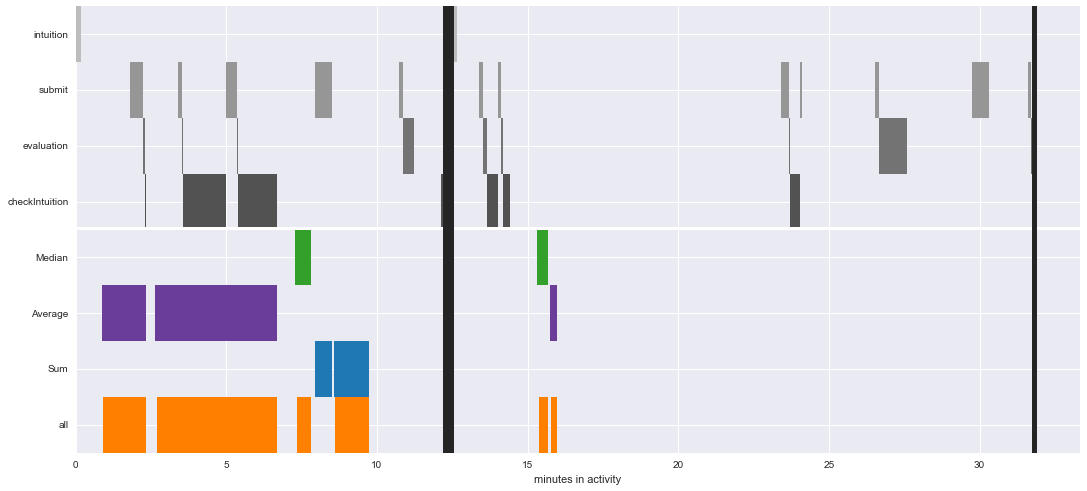

In [8]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot()
spacing =10
pos = 0
max_time = 0
actions = list(reversed(to_plot))
black = '#252525'
for i,action in enumerate(actions):
    action_use = get_action_usage(df_test,column_to_use[action],action)
    max_time = max(max_time,sum(action_use[-1]))
    ax.broken_barh(action_use,(pos,spacing),facecolors=color[action],alpha=1,linewidth=0)
    pos += spacing

#Add horizontal bar
ax.broken_barh([(0,ax.get_xlim()[1])],(40,0.5),facecolors='white',alpha=1,linewidth=0)

#Add new case bar
new_case = "Now try working on this new example"
action_use = get_action_usage(df_test,column_to_use[new_case],new_case)
max_time = max(max_time,sum(action_use[-1]))
ax.broken_barh(action_use,(0,len(actions)*spacing),facecolors=black,alpha=1,linewidth=0)

ax.set_xlabel('minutes in activity')
ax.set_xticks(range(0,int(max_time),60*5))
ax.set_xticklabels([str(x/60)+'' for x in range(0,int(max_time),60*5)])
ax.set_yticks(range(spacing/2,len(actions)*spacing,spacing))
ax.set_yticklabels(actions)
ax.grid(True)
plt.show()

The black vertical bar in the graph shows when a "new case" is presented

### TODO
* figure out why overlap? for example between submit and evaluation
* add non ready made functions

In [9]:
df_test

,Row ID,login name,condition1,condition2,student1,student2,student 3,class,Session Id,time first action,time last action,Time,Time Taken,Problem Name,Step Name,Attempt At Step,Outcome,Selection,Graph #,Method_Recognized_1_Copied,Method_Recognized_2_Copied,Action,Input,Next_Input,Feedback Text,CF(Method1),CF(Method2),CF(advice),CF(new1),CF(new2),CF(step1_1),CF(step1_2),CF(step1_3),CF(step1_4),CF(step1_5),CF(step1_6),CF(step1_7),CF(step1_8),CF(step2_1),CF(step2_2),CF(step2_3),CF(step2_4),CF(step2_5),CF(step2_6),CF(step2_7),CF(step2_8),Unnamed: 46,Unnamed: 47,Unnamed: 48,Input.1,Next_Input.1,Time_seconds,Timeshifted,Duration
15384,ID25386,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,00:57:29,NaN,00:57:29,NaN,trampoline,intuition UpdateComboBox,1.0,CORRECT,intuition,NaN,st1,st1,UpdateComboBox,Trampoline B,Dormin Button,Good. Now please work on part 2.,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,00:57:40,11.0
15385,ID25387,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:57:40,00:00:11,trampoline,button1_9 ButtonPressed,1.0,CORRECT,button1_9,1.0,st1 9,st1,ButtonPressed,Dormin Button,Average,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,00:58:11,31.0
15388,ID25390,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:58:11,00:00:09,trampoline,delete1 ButtonPressed,1.0,CORRECT,delete1,1.0,st1,st1,ButtonPressed,Delete step,Average,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,00:58:21,10.0
15389,ID25391,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:58:21,00:00:10,trampoline,function1 UpdateComboBox,2.0,CORRECT,function1,1.0,st1 Average,st1,UpdateComboBox,Average,all,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,00:58:24,3.0
15390,ID25392,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:58:24,00:00:03,trampoline,pointsSelection1 UpdateComboBox,2.0,CORRECT,pointsSelection1,1.0,st1 Average all,st1,UpdateComboBox,all,Average,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,00:58:38,14.0
15391,ID25393,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:58:38,00:00:14,trampoline,function2 UpdateComboBox,1.0,CORRECT,function2,2.0,st1 Average all,st1 Average,UpdateComboBox,Average,all,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0,00:58:41,3.0
15392,ID25394,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:58:41,00:00:03,trampoline,pointsSelection2 UpdateComboBox,1.0,CORRECT,pointsSelection2,2.0,st1 Average all,st1 Average all,UpdateComboBox,all,They are the same,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,00:59:11,30.0
15395,ID25397,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:59:11,00:00:07,trampoline,use2 ButtonPressed,1.0,CORRECT,use2,2.0,st1 Average all,st1 Average all Use,ButtonPressed,Use,Use,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,00:59:13,2.0
15396,ID25398,penguin8gorilla8,Sava